In [44]:
from google.colab import files
uploaded=files.upload()

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset (2).csv


In [45]:
!pip install lime

In [46]:
!pip install shap

In [105]:
import shap
shap.initjs()

In [47]:
! pip install eli5

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.utils.metaestimators as if_delegate_has_method

# Load dataset
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [49]:
# Task 1: EDA
print(data.head())

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [51]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [52]:
# Correlation matrix
corr_matrix = data.corr()
corr_matrix

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068,0.253729
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


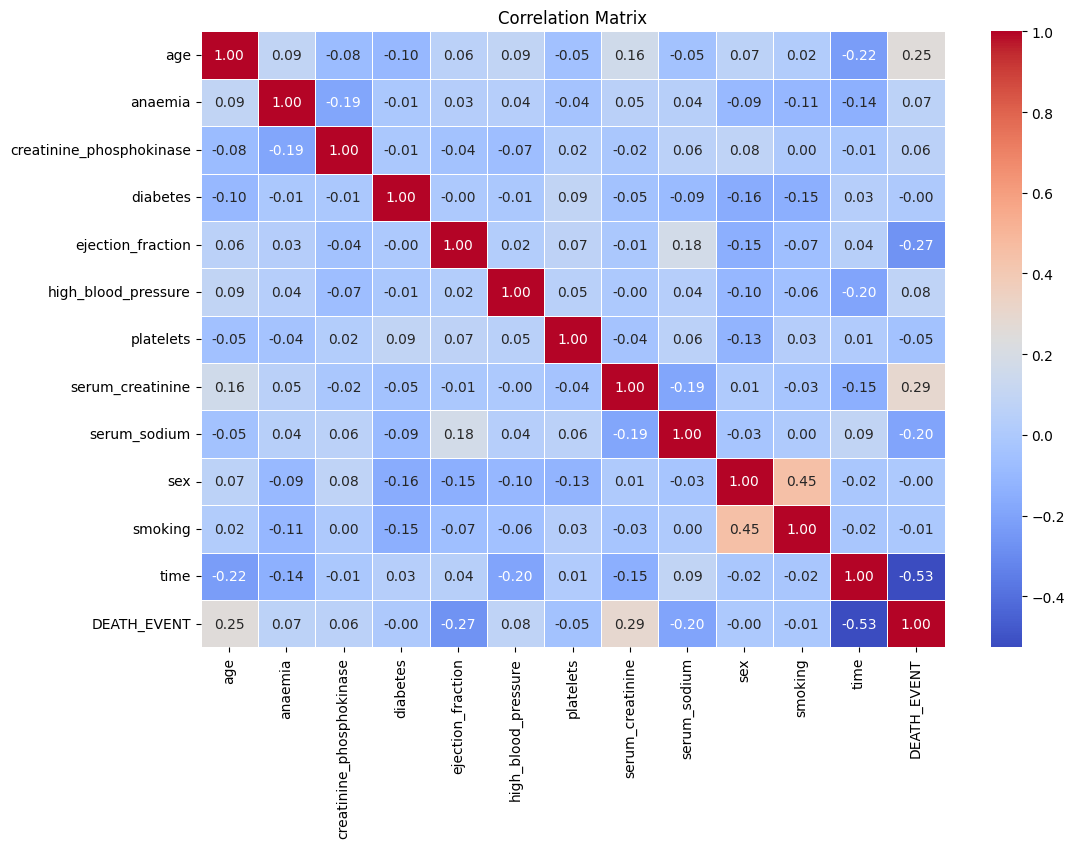

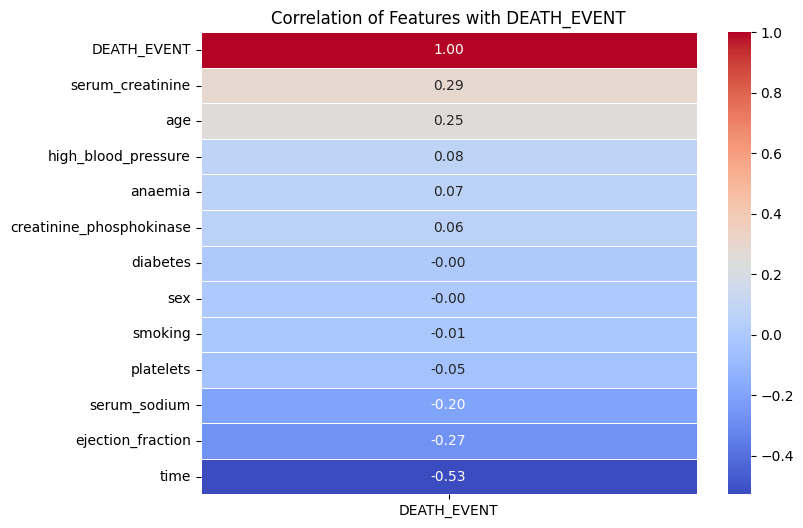

In [53]:
# Plot correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Plot correlation of features with the target variable
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr()[['DEATH_EVENT']].sort_values(by='DEATH_EVENT', ascending=False),
            cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation of Features with DEATH_EVENT")
plt.show()

In [54]:
# Separate features and target variable
X = data.drop(columns=['DEATH_EVENT'])
y = data['DEATH_EVENT']

In [55]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

In [58]:
# Define hyperparameters for tuning
parameters = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [3, 5, 7, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    'XGBoost': {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7]}
}

In [59]:
# Perform hyperparameter tuning
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, parameters[name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train_scaled if 'Logistic Regression' in name else X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Best ROC-AUC score for {name}: {grid_search.best_score_}")

Best hyperparameters for Logistic Regression: {'C': 1}
Best ROC-AUC score for Logistic Regression: 0.8954587895764368
Best hyperparameters for Decision Tree: {'max_depth': 3}
Best ROC-AUC score for Decision Tree: 0.8385090399796283
Best hyperparameters for Random Forest: {'max_depth': 5, 'n_estimators': 200}
Best ROC-AUC score for Random Forest: 0.9408921144215263
Best hyperparameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3}
Best ROC-AUC score for XGBoost: 0.9252380952380952


In [60]:
# Evaluate models on test set
for name, model in best_models.items():
    if 'Logistic Regression' in name:
        y_pred = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred.round())
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}, ROC-AUC: {roc_auc}")

Logistic Regression - Accuracy: 0.8, ROC-AUC: 0.824
Decision Tree - Accuracy: 0.6833333333333333, ROC-AUC: 0.672
Random Forest - Accuracy: 0.7666666666666667, ROC-AUC: 0.8411428571428572
XGBoost - Accuracy: 0.7333333333333333, ROC-AUC: 0.8708571428571429


In [61]:
import eli5
from eli5.sklearn import PermutationImportance
best_lr_model = grid_search.best_estimator_

# Visualize feature weights
eli5.show_weights(best_lr_model, feature_names=X.columns.tolist())

Weight,Feature
0.3071,time
0.2302,serum_creatinine
0.0746,ejection_fraction
0.0604,serum_sodium
0.0569,age
0.0517,creatinine_phosphokinase
0.0442,sex
0.0433,platelets
0.0425,diabetes
0.0319,high_blood_pressure


In [66]:
#######

In [68]:
# Logistic Regression
lr = LogisticRegression()
param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X, y)
print('Logistic Regression:')
print('Best parameters:', grid_search_lr.best_params_)
print('Best accuracy:', grid_search_lr.best_score_)
print('AUC-ROC:', roc_auc_score(y, grid_search_lr.predict_proba(X)[:, 1]))

# Decision Tree
dt = DecisionTreeClassifier()
param_grid_dt = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X, y)
print('Decision Tree:')
print('Best parameters:', grid_search_dt.best_params_)
print('Best accuracy:', grid_search_dt.best_score_)
print('AUC-ROC:', roc_auc_score(y, grid_search_dt.predict_proba(X)[:, 1]))

# Random Forest
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X, y)
print('Random Forest:')
print('Best parameters:', grid_search_rf.best_params_)
print('Best accuracy:', grid_search_rf.best_score_)
print('AUC-ROC:', roc_auc_score(y, grid_search_rf.predict_proba(X)[:, 1]))

# XGBoost
xgb = XGBClassifier()
param_grid_xgb = {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X, y)
print('XGBoost:')
print('Best parameters:', grid_search_xgb.best_params_)
print('Best accuracy:', grid_search_xgb.best_score_)
print('AUC-ROC:', roc_auc_score(y, grid_search_xgb.predict_proba(X)[:, 1]))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression:
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best accuracy: 0.7822598870056497
AUC-ROC: 0.8725882594417077
Decision Tree:
Best parameters: {'max_depth': 7, 'min_samples_split': 10}
Best accuracy: 0.6489265536723163
AUC-ROC: 0.982835591133005
Random Forest:
Best parameters: {'max_depth': 5, 'n_estimators': 50}
Best accuracy: 0.7156497175141243
AUC-ROC: 0.9854269293924467
XGBoost:
Best parameters: {'learning_rate': 0.01, 'max_depth': 3}
Best accuracy: 0.6789265536723164
AUC-ROC: 0.9513290229885059


In [72]:
# 3. Perform Machine Learning Interpretability / Explainability

# Logistic Regression Interpretation
print('Logistic Regression Interpretation:')
eli5.show_weights(grid_search_lr.best_estimator_, top=10)

Logistic Regression Interpretation:


In [73]:
# Decision Tree Interpretation
print('Decision Tree Interpretation:')
perm = PermutationImportance(grid_search_dt.best_estimator_).fit(X, y)
eli5.show_weights(perm, top=10)

Decision Tree Interpretation:


Weight,Feature
0.2662 ± 0.0482,x11
0.1003 ± 0.0356,x7
0.0508 ± 0.0115,x4
0.0428 ± 0.0123,x2
0.0381 ± 0.0197,x6
0.0241 ± 0.0098,x8
0.0221 ± 0.0068,x5
0 ± 0.0000,x3
0 ± 0.0000,x9
0 ± 0.0000,x10


In [75]:
# Pick a row with negative label (Logistic Regression)
neg_example = X.iloc[0]
neg_label = y.iloc[0]
print(f'Negative example: {neg_example}')
print(f'Negative label: {neg_label}')
eli5.show_prediction(grid_search_lr.best_estimator_, neg_example, target_names=['Survived', 'Died'])

Negative example: age                             75.0
anaemia                          0.0
creatinine_phosphokinase       582.0
diabetes                         0.0
ejection_fraction               20.0
high_blood_pressure              1.0
platelets                   265000.0
serum_creatinine                 1.9
serum_sodium                   130.0
sex                              1.0
smoking                          0.0
time                             4.0
Name: 0, dtype: float64
Negative label: 1
Positive example: age                             50.0
anaemia                          0.0
creatinine_phosphokinase       196.0
diabetes                         0.0
ejection_fraction               45.0
high_blood_pressure              0.0
platelets                   395000.0
serum_creatinine                 1.6
serum_sodium                   136.0
sex                              1.0
smoking                          1.0
time                           285.0
Name: 298, dtype: float64
Positive

In [82]:
# Pick a row with positive label (Logistic Regression)
pos_example = X.iloc[-1]
pos_label = y.iloc[-1]
print(f'Positive example: {pos_example}')
print(f'Positive label: {pos_label}')
eli5.show_prediction(grid_search_lr.best_estimator_, pos_example, target_names=['Survived', 'Died'])

Positive example: age                             50.0
anaemia                          0.0
creatinine_phosphokinase       196.0
diabetes                         0.0
ejection_fraction               45.0
high_blood_pressure              0.0
platelets                   395000.0
serum_creatinine                 1.6
serum_sodium                   136.0
sex                              1.0
smoking                          1.0
time                           285.0
Name: 298, dtype: float64
Positive label: 0


In [81]:
# b. Decision Tree Interpretability

# List the feature importance ordered by the highest value
print('Decision Tree Feature Importance:')
perm = PermutationImportance(grid_search_dt.best_estimator_).fit(X, y)
eli5.show_weights(perm, top=len(X.columns))

Decision Tree Feature Importance:


Weight,Feature
0.2776 ± 0.0328,x11
0.0923 ± 0.0380,x7
0.0575 ± 0.0266,x4
0.0421 ± 0.0162,x6
0.0381 ± 0.0172,x2
0.0321 ± 0.0080,x8
0.0214 ± 0.0124,x5
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x3


In [83]:
# Negative example (Decision Tree)
neg_example = X.iloc[0]
neg_label = y.iloc[0]
print(f'Negative example: {neg_example}')
print(f'Negative label: {neg_label}')
eli5.show_prediction(grid_search_dt.best_estimator_, neg_example, target_names=['Survived', 'Died'])

Negative example: age                             75.0
anaemia                          0.0
creatinine_phosphokinase       582.0
diabetes                         0.0
ejection_fraction               20.0
high_blood_pressure              1.0
platelets                   265000.0
serum_creatinine                 1.9
serum_sodium                   130.0
sex                              1.0
smoking                          0.0
time                             4.0
Name: 0, dtype: float64
Negative label: 1


In [84]:
# Positive example (Decision Tree)
pos_example = X.iloc[-1]
pos_label = y.iloc[-1]
print(f'Positive example: {pos_example}')
print(f'Positive label: {pos_label}')
eli5.show_prediction(grid_search_dt.best_estimator_, pos_example, target_names=['Survived', 'Died'])

Positive example: age                             50.0
anaemia                          0.0
creatinine_phosphokinase       196.0
diabetes                         0.0
ejection_fraction               45.0
high_blood_pressure              0.0
platelets                   395000.0
serum_creatinine                 1.6
serum_sodium                   136.0
sex                              1.0
smoking                          1.0
time                           285.0
Name: 298, dtype: float64
Positive label: 0


In [89]:
# LIME for Random Forest and XGBoost
lime_explainer = LimeTabularExplainer(X.values, feature_names=X.columns)

In [90]:
# Random Forest LIME Interpretation
rf_prediction = grid_search_rf.predict_proba(X)
rf_exp = lime_explainer.explain_instance(X.iloc[0], grid_search_rf.predict_proba)
print('Random Forest LIME Explanation:')
print(rf_exp.as_list())
print('Random Forest LIME Coefficients:', rf_exp.local_exp)
print('Random Forest LIME Intercept:', rf_exp.intercept[1])
print('Random Forest LIME R2:', rf_exp.score)

Random Forest LIME Explanation:
[('time <= 73.00', 0.4521609751882125), ('serum_creatinine > 1.40', 0.17670187521832922), ('ejection_fraction <= 30.00', 0.13699418573314903), ('age > 70.00', 0.07809227204064909), ('serum_sodium <= 134.00', 0.053558443534590265), ('250.00 < creatinine_phosphokinase <= 582.00', 0.013057998979201247), ('0.00 < sex <= 1.00', -0.012522294361086601), ('anaemia <= 0.00', -0.012125067184898336), ('0.00 < high_blood_pressure <= 1.00', 0.008474514731236255), ('262000.00 < platelets <= 303500.00', -0.00606303484709265)]
Random Forest LIME Coefficients: {1: [(11, 0.4521609751882125), (7, 0.17670187521832922), (4, 0.13699418573314903), (0, 0.07809227204064909), (8, 0.053558443534590265), (2, 0.013057998979201247), (9, -0.012522294361086601), (1, -0.012125067184898336), (5, 0.008474514731236255), (6, -0.00606303484709265)]}
Random Forest LIME Intercept: 0.12749818933634088
Random Forest LIME R2: 0.8550935010093559


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [91]:
# XGBoost LIME Interpretation
xgb_prediction = grid_search_xgb.predict_proba(X)
xgb_exp = lime_explainer.explain_instance(X.iloc[0], grid_search_xgb.predict_proba)
print('XGBoost LIME Explanation:')
print(xgb_exp.as_list())
print('XGBoost LIME Coefficients:', xgb_exp.local_exp)
print('XGBoost LIME Intercept:', xgb_exp.intercept[1])
print('XGBoost LIME R2:', xgb_exp.score)

XGBoost LIME Explanation:
[('time <= 73.00', 0.386414449878174), ('serum_creatinine > 1.40', 0.12114485567064556), ('ejection_fraction <= 30.00', 0.08835678432619089), ('age > 70.00', 0.03169861582612886), ('serum_sodium <= 134.00', 0.013481788381412922), ('250.00 < creatinine_phosphokinase <= 582.00', 0.009494159995334615), ('smoking <= 0.00', 0.0035382689004112722), ('anaemia <= 0.00', 0.002518166126158685), ('0.00 < high_blood_pressure <= 1.00', 0.002277272051990739), ('0.00 < sex <= 1.00', -0.0012101097876030425)]
XGBoost LIME Coefficients: {1: [(11, 0.386414449878174), (7, 0.12114485567064556), (4, 0.08835678432619089), (0, 0.03169861582612886), (8, 0.013481788381412922), (2, 0.009494159995334615), (10, 0.0035382689004112722), (1, 0.002518166126158685), (5, 0.002277272051990739), (9, -0.0012101097876030425)]}
XGBoost LIME Intercept: 0.1665797103175742
XGBoost LIME R2: 0.9018307490400304


In [93]:
# SHAP for XGBoost
shap_explainer = shap.TreeExplainer(grid_search_xgb.best_estimator_)
shap_values = shap_explainer.shap_values(X)

In [94]:
# Visualize explanations for positive and negative examples
base_value = shap_explainer.expected_value

In [108]:
# Negative example
neg_example = X.iloc[0]
neg_shap_values = shap_values[0]
print('Negative Example SHAP Explanation:')
shap.force_plot(base_value, neg_shap_values, neg_example)

Negative Example SHAP Explanation:


In [107]:
# Positive example
pos_example = X.iloc[-1]
pos_shap_values = shap_values[-1]
print('Positive Example SHAP Explanation:')
shap.force_plot(base_value, pos_shap_values, pos_example)

Positive Example SHAP Explanation:


SHAP Feature Importance:


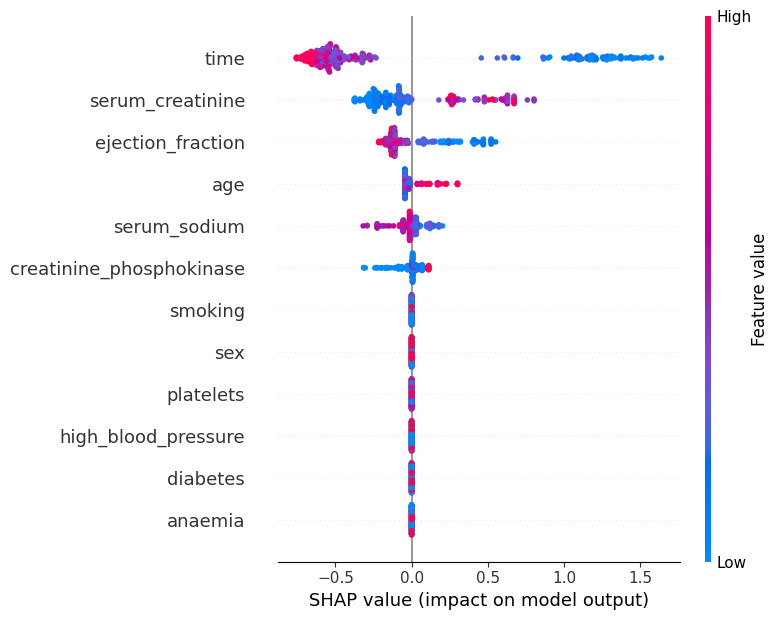

In [100]:
# Feature importance plot
print('SHAP Feature Importance:')
shap.summary_plot(shap_values, X)

In [111]:
# 4. Predict observations and evaluate model performance
print('Model Predictions:')
print('False/True label: 0/1')

# Logistic Regression
lr_probs = grid_search_lr.predict_proba(X.iloc[[0, -1]])
print('LR: ', lr_probs)

# Decision Tree
dt_probs = grid_search_dt.predict_proba(X.iloc[[0, -1]])
print('DT: ', dt_probs)

# Random Forest
rf_probs = grid_search_rf.predict_proba(X.iloc[[0, -1]])
print('RF: ', rf_probs)

# XGBoost
xgb_probs = grid_search_xgb.predict_proba(X.iloc[[0, -1]])
print('XGB:', xgb_probs)

Model Predictions:
False/True label: 0/1
LR:  [[0.04024297 0.95975703]
 [0.99623393 0.00376607]]
DT:  [[0. 1.]
 [1. 0.]]
RF:  [[0.03594984 0.96405016]
 [0.93216305 0.06783695]]
XGB: [[0.28470576 0.71529424]
 [0.76881677 0.23118325]]
